In [38]:
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
import warnings
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import sys
sys.path.append('src')
# from src.non_snow_retrievals import canopy_permittivity, vegetation_phase
from src.swe_retrievals import calc_soil_moisture_error, calc_veg_permittivity_error

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter('ignore', SettingWithCopyWarning)


/Users/ropa5718/github/SWE_error_analysis/src/swe_retrievals.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  veg_phase.append(float(vegetation_phase(H=canopy_height, epsilon_1=e1, epsilon_2=e2)))
/Users/ropa5718/github/SWE_error_analysis/src/swe_retrievals.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  veg_phase.append(float(vegetation_phase(H=canopy_height, epsilon_1=e1, epsilon_2=e2)))


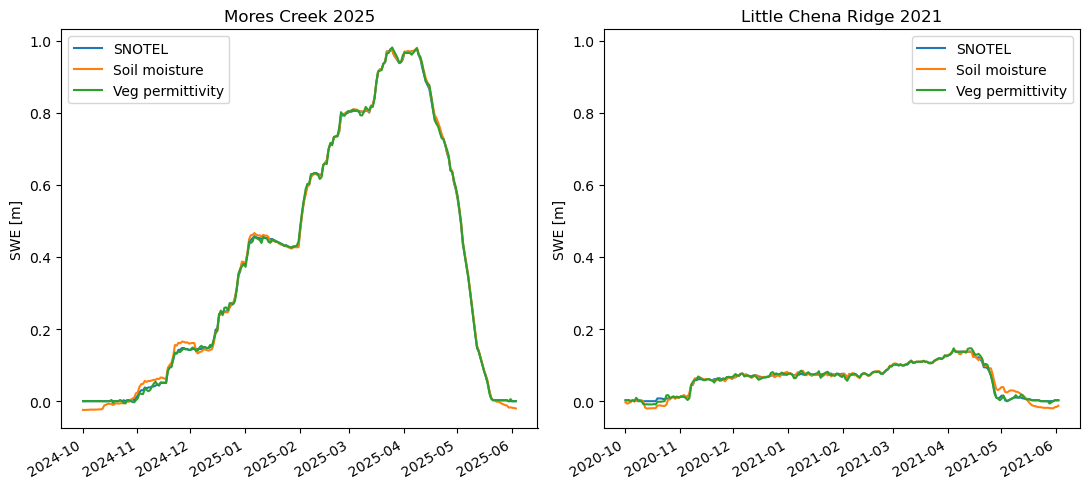

In [6]:
mores = pd.read_csv('../data_sandbox/swe_errors/snotel/hourly/637_ALL_WATERYEAR=2025.csv', header=1, 
                    parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct)  (silt)':'sm_2cm'})
mores.index = mores['Date_Time']
mores.drop(columns=['Site Id','Date_Time'], inplace=True)
mores = mores[mores.index.hour==6]
mores['swe'] *= 0.0254

chena = pd.read_csv('../data_sandbox/swe_errors/snotel/hourly/947_ALL_WATERYEAR=2021.csv', header=1, 
                    parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct) ':'sm_2cm'})
chena.index = chena['Date_Time']
chena.drop(columns=['Site Id','Date_Time'], inplace=True)
chena['swe'] *= 0.0254
chena = chena.loc[:'2021-06-02']
chena = chena[chena.index.hour==6]

# Soil moisture
mores_sand = 45.1
mores_clay = 14.4
mores['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores['sm_2cm']/100) + mores['swe']

chena_sand = 31.2
chena_clay = 11.8
chena['soil_error'] = calc_soil_moisture_error(chena_sand, chena_clay, chena['sm_2cm']/100) + chena['swe']


# Vegetation permittivity
mores_veg_height = 6
mores['veg_error'] = calc_veg_permittivity_error(canopy_height=mores_veg_height, temperature_series=mores['TAVG.H-1 (degC) ']) + mores['swe']

chena_veg_height = 5
chena['veg_error'] = calc_veg_permittivity_error(canopy_height=chena_veg_height, temperature_series=chena['TOBS.I-1 (degC) ']) + chena['swe']



fig, ax = plt.subplots(1, 2, figsize=(11,5))
mores['swe'].plot(ax=ax[0], label='SNOTEL')
mores['soil_error'].plot(ax=ax[0], label='Soil moisture')
mores['veg_error'].plot(ax=ax[0], label='Veg permittivity')
ax[0].set_title('Mores Creek 2025')
ax[0].set_xlabel('')
ax[0].set_ylabel('SWE [m]')
ax[0].legend()

chena['swe'].plot(ax=ax[1], label='SNOTEL')
chena['soil_error'].plot(ax=ax[1], label='Soil moisture')
chena['veg_error'].plot(ax=ax[1], label='Veg permittivity')
ax[1].set_title('Little Chena Ridge 2021')
ax[1].set_xlabel('')
ax[1].set_ylabel('SWE [m]')
ax[1].set_ylim(ax[0].get_ylim())
ax[1].legend()

plt.tight_layout()


# for axx in ax.flatten():
#     axx.set_ylim([-0.02, 1.02])

In [4]:
chena.columns

Index(['swe', 'PREC.I-1 (in) ', 'PREC.I-2 (in) ', 'TOBS.I-1 (degC) ',
       'SNWD.I-1 (in) ', 'sm_2cm', 'SMS.I-1:-8 (pct) ', 'SMS.I-1:-20 (pct) ',
       'STO.I-1:0 (degC) ', 'STO.I-1:-2 (degC) ', 'STO.I-1:-8 (degC) ',
       'STO.I-1:-20 (degC) ', 'BATT.I-1 (volt) ', 'WDIRV.H-1 (degr) ',
       'WSPDX.H-1 (mph) ', 'WSPDV.H-1 (mph) ', 'SRADV.H-1 (watt) ',
       'Unnamed: 20', 'soil_error'],
      dtype='object')

In [9]:
mores_files = sorted(glob('../data_sandbox/swe_errors/snotel/hourly/637*.csv'))
mores = pd.read_csv(mores_files[0], header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct)  (silt)':'sm_2cm'})
mores.index = mores['Date_Time']
mores.drop(columns=['Date_Time', 'Site Id'], inplace=True)

for f in mores_files[1:]:
    df_tmp = pd.read_csv(f, header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct)  (silt)':'sm_2cm'})
    df_tmp.index = df_tmp['Date_Time']
    df_tmp.drop(columns=['Date_Time', 'Site Id'], inplace=True)
    mores = pd.concat([mores, df_tmp])

mores['WaterYear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in mores.index]
mores = mores[[c for c in mores.columns if 'Unnamed' not in c]]


chena_files = sorted(glob('../data_sandbox/swe_errors/snotel/hourly/947*.csv'))
chena = pd.read_csv(chena_files[0], header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct) ':'sm_2cm'})
chena.index = chena['Date_Time']
chena.drop(columns=['Date_Time', 'Site Id'], inplace=True)

for f in chena_files[1:]:
    df_tmp = pd.read_csv(f, header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct) ':'sm_2cm'})
    df_tmp.index = df_tmp['Date_Time']
    df_tmp.drop(columns=['Date_Time', 'Site Id'], inplace=True)
    chena = pd.concat([chena, df_tmp])

chena['WaterYear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in chena.index]
chena = chena[[c for c in chena.columns if 'Unnamed' not in c]]



for df in [mores, chena]:
    df['dowy'] = [(r[0] - pd.to_datetime(f'{int(r[1]["WaterYear"])-1}-10-01')) for r in df.iterrows()] # type: ignore
    df['dowy'] = df['dowy'].dt.days + 1

    
    


/var/folders/qw/0hrz2r9d1hgffvdv588xr_9r0000gp/T/ipykernel_11050/3505388986.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mores_6am['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores_6am['sm_2cm']/100)
/var/folders/qw/0hrz2r9d1hgffvdv588xr_9r0000gp/T/ipykernel_11050/3505388986.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mores_6pm['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores_6pm['sm_2cm']/100)
/var/folders/qw/0hrz2r9d1hgffvdv588xr_9r0000gp/T/ipyker

[Text(1, 0, 'Oct'),
 Text(32, 0, 'Nov'),
 Text(62, 0, 'Dec'),
 Text(93, 0, 'Jan'),
 Text(124, 0, 'Feb'),
 Text(152, 0, 'Mar'),
 Text(183, 0, 'Apr'),
 Text(213, 0, 'May'),
 Text(244, 0, 'Jun')]

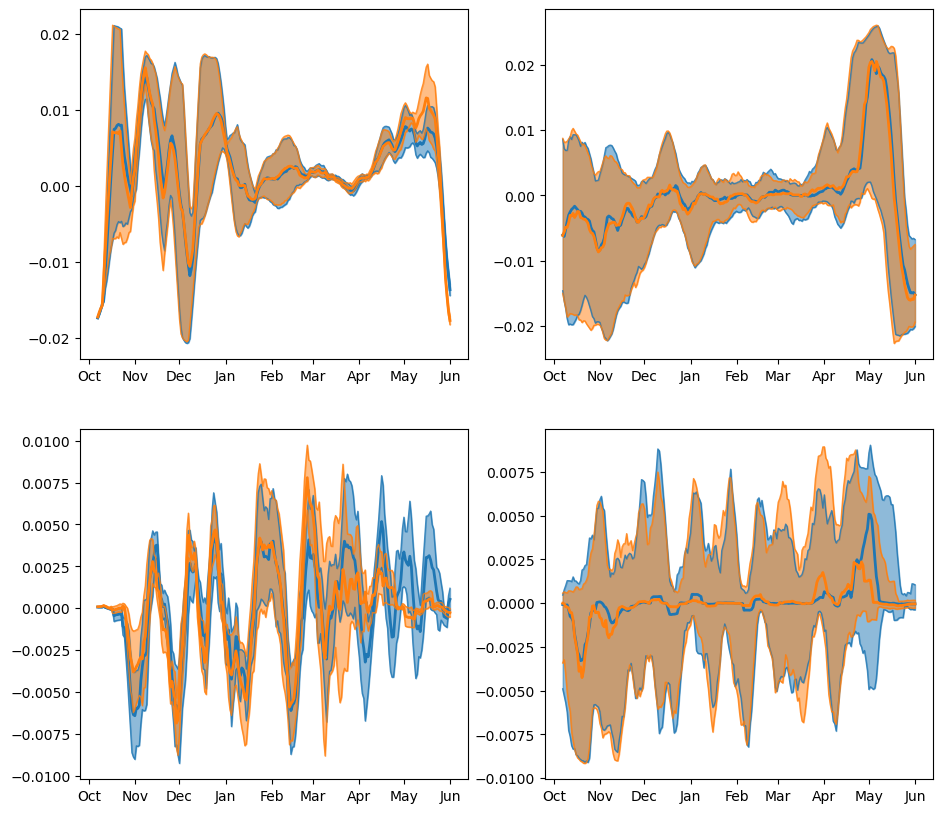

In [ ]:
mores_sand = 45.1
mores_clay = 14.4

chena_sand = 31.2
chena_clay = 11.8

mores_6am = mores.loc[mores.index.hour==6]
mores_6pm = mores.loc[mores.index.hour==18]
mores_6am['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores_6am['sm_2cm']/100)
mores_6pm['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores_6pm['sm_2cm']/100)

chena_6am = chena.loc[chena.index.hour==6]
chena_6pm = chena.loc[chena.index.hour==18]
chena_6am['soil_error'] = calc_soil_moisture_error(chena_sand, chena_clay, chena_6am['sm_2cm']/100)
chena_6pm['soil_error'] = calc_soil_moisture_error(chena_sand, chena_clay, chena_6pm['sm_2cm']/100)

mores_veg_height = 6
mores_6am['veg_error'] = calc_veg_permittivity_error(canopy_height=mores_veg_height, temperature_series=mores_6am['TAVG.H-1 (degC) '])
mores_6pm['veg_error'] = calc_veg_permittivity_error(canopy_height=mores_veg_height, temperature_series=mores_6pm['TAVG.H-1 (degC) '])


chena_veg_height = 5
chena_6am['veg_error'] = calc_veg_permittivity_error(canopy_height=chena_veg_height, temperature_series=chena_6am['TOBS.I-1 (degC) '])
chena_6pm['veg_error'] = calc_veg_permittivity_error(canopy_height=chena_veg_height, temperature_series=chena_6pm['TOBS.I-1 (degC) '])



mores6am_gb = mores_6am.loc[mores['dowy']<=244].groupby('dowy')
mores6pm_gb = mores_6pm.loc[mores['dowy']<=244].groupby('dowy')
chena6am_gb = chena_6am.loc[chena['dowy']<=244].groupby('dowy')
chena6pm_gb = chena_6pm.loc[chena['dowy']<=244].groupby('dowy')




fig, ax = plt.subplots(2, 2, figsize=(11,10))
# Soil error
ax[0,0].fill_between(mores6am_gb.quantile(0.1)['soil_error'].index, mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[0,0].plot(mores6am_gb.median()['soil_error'].rolling(7).mean(), lw=2)
ax[0,0].plot(mores6am_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[0,0].plot(mores6am_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[0,0].fill_between(mores6pm_gb.quantile(0.1)['soil_error'].index, mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[0,0].plot(mores6pm_gb.median()['soil_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[0,0].plot(mores6pm_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[0,0].plot(mores6pm_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[0,0].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[0,0].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

ax[0,1].fill_between(chena6am_gb.quantile(0.1)['soil_error'].index, chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[0,1].plot(chena6am_gb.median()['soil_error'].rolling(7).mean(), lw=2)
ax[0,1].plot(chena6am_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[0,1].plot(chena6am_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[0,1].fill_between(chena6pm_gb.quantile(0.1)['soil_error'].index, chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[0,1].plot(chena6pm_gb.median()['soil_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[0,1].plot(chena6pm_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[0,1].plot(chena6pm_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[0,1].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[0,1].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

# Veg error
ax[1,0].fill_between(mores6am_gb.quantile(0.1)['veg_error'].index, mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[1,0].plot(mores6am_gb.median()['veg_error'].rolling(7).mean(), lw=2)
ax[1,0].plot(mores6am_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[1,0].plot(mores6am_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[1,0].fill_between(mores6pm_gb.quantile(0.1)['veg_error'].index, mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[1,0].plot(mores6pm_gb.median()['veg_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[1,0].plot(mores6pm_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[1,0].plot(mores6pm_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[1,0].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[1,0].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

ax[1,1].fill_between(chena6am_gb.quantile(0.1)['veg_error'].index, chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[1,1].plot(chena6am_gb.median()['veg_error'].rolling(7).mean(), lw=2)
ax[1,1].plot(chena6am_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[1,1].plot(chena6am_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[1,1].fill_between(chena6pm_gb.quantile(0.1)['veg_error'].index, chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[1,1].plot(chena6pm_gb.median()['veg_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[1,1].plot(chena6pm_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[1,1].plot(chena6pm_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[1,1].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[1,1].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

ax[0,0].set_title('Mores Creek Summit')


# ax[0].plot(mores_6pm.groupby('dowy').median()['soil_error'])



In [63]:
gb.mean()

,swe,PREC.I-1 (in),PREC.I-2 (in),TOBS.I-1 (degC),SNWD.I-1 (in),sm_2cm,SMS.I-1:-8 (pct),SMS.I-1:-20 (pct),STO.I-1:0 (degC),STO.I-1:-2 (degC),...,SRADV.H-1 (watt),PRES.I-1 (mbar),DIAG.I-1 (unit),DIAG.I-2 (unit),DIAG.I-3 (unit),DIAG.I-4 (unit),DIAG.I-5 (unit),DIAG.I-6 (unit),WaterYear,soil_error
dowy,,,,,,,,,,,,,,,,,,,,,
1,0.144444,0.000000,0.000000,2.280000,2.200000,13.100000,21.760000,29.530000,4.230000,2.090000,...,0.122000,932.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.5,-0.000488
2,0.144444,0.066667,0.054000,2.880000,11.100000,13.040000,21.800000,29.360000,4.330000,2.280000,...,0.118000,932.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.5,-0.003816
3,0.237500,0.155556,0.060000,2.300000,11.300000,12.720000,21.670000,29.350000,4.140000,2.000000,...,0.120000,931.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.5,-0.004262
4,0.255556,0.270000,0.102000,1.950000,2.800000,12.610000,21.570000,29.330000,4.090000,1.850000,...,0.125000,917.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.5,-0.005158
5,0.322222,0.290000,0.205000,1.980000,2.400000,12.090000,21.800000,29.400000,3.940000,1.700000,...,0.131000,910.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.5,-0.004729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.037500,22.214286,24.298889,0.255556,0.888889,13.088889,21.600000,29.377778,4.911111,2.688889,...,0.132222,924.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,0.002462
363,0.000000,22.200000,24.334444,0.377778,0.888889,13.122222,21.522222,29.344444,4.811111,2.544444,...,0.184444,929.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,0.005424
364,0.025000,22.342857,24.413333,1.077778,0.777778,13.155556,21.611111,29.455556,4.611111,2.433333,...,0.107778,933.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,0.004386


In [55]:
sturm = rxr.open_rasterio('../data_sandbox/swe_errors/SnowClass_NA_300m_10.0arcsec_2021_v01.0.tif')
landfire = rxr.open_rasterio('../data_sandbox/swe_errors/LF2023_EVH_240_CONUS/Tif/LC23_EVH_240.tif')
sites = pd.read_csv('../data_sandbox/swe_errors/snotel/fig4_sites.csv')
sites['sturm'] = sites.apply(lambda site: int(sturm.sel(x=site['lon'], y=site['lat'], method='nearest')), axis=1)
sites_wgs84 = gpd.GeoDataFrame(sites, geometry=gpd.points_from_xy(x=sites['lon'], y=sites['lat']), crs='epsg:4326')
sites_nad83 = sites_wgs84.to_crs(landfire.rio.crs)
sites['landfire'] = sites_nad83.apply(lambda site: int(landfire.sel(x=site.geometry.x, y=site.geometry.y, method='nearest')), axis=1)
sites

,ecoregion,station_name,station_id,lat,lon,sand,clay,sturm,landfire
0,North Cascades,Paradise,679,46.7830,-121.7500,748,19,3,112
1,Cascades,Clackamas Lake,398,45.1000,-121.7500,524,164,4,304
2,Eastern Cascades,Annie Springs,1000,42.8670,-122.1670,705,24,3,31
3,Sierra Nevada,Virginia Lakes Rdg,846,38.0670,-119.2330,596,81,6,115
4,Blue Mountains,Tipton,821,44.6500,-118.4300,386,95,6,119
5,Northern Basin and Range,Silvies,759,42.7500,-118.6830,397,224,5,208
6,Central Basin and Range,Corral Canyon,417,40.2833,-115.5330,430,190,5,113
7,Columbia Mtns/Northern Rockies,Sunset,803,47.5500,-115.8167,304,110,6,120
8,Idaho Batholith,Galena Summit,490,43.8667,-114.7160,497,126,2,205
9,Middle Rockies,Lewis Lake Divide,577,44.2167,-110.6660,462,118,5,207


In [56]:
sites['canopy_height'] = [12,0.4,0,15,19,0.8,13,20,0.5,0.7,13,11,0.2]
sites

,ecoregion,station_name,station_id,lat,lon,sand,clay,sturm,landfire,canopy_height
0,North Cascades,Paradise,679,46.7830,-121.7500,748,19,3,112,12.0
1,Cascades,Clackamas Lake,398,45.1000,-121.7500,524,164,4,304,0.4
2,Eastern Cascades,Annie Springs,1000,42.8670,-122.1670,705,24,3,31,0.0
3,Sierra Nevada,Virginia Lakes Rdg,846,38.0670,-119.2330,596,81,6,115,15.0
4,Blue Mountains,Tipton,821,44.6500,-118.4300,386,95,6,119,19.0
5,Northern Basin and Range,Silvies,759,42.7500,-118.6830,397,224,5,208,0.8
6,Central Basin and Range,Corral Canyon,417,40.2833,-115.5330,430,190,5,113,13.0
7,Columbia Mtns/Northern Rockies,Sunset,803,47.5500,-115.8167,304,110,6,120,20.0
8,Idaho Batholith,Galena Summit,490,43.8667,-114.7160,497,126,2,205,0.5
9,Middle Rockies,Lewis Lake Divide,577,44.2167,-110.6660,462,118,5,207,0.7


In [57]:
sites.to_csv('../data_sandbox/swe_errors/snotel/fig4_sites.csv')